In [84]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
# plt.style.use(['seaborn-notebook'])

In [3]:
# custom libraries
import sys, os
sys.path.append(os.path.abspath('../../spaths'))
import spaths

In [95]:
# underlying OU process coefficients
def drift_ou(t, u, du):
    du[0] = 0.01
    du[1] = u[0] - u[1]

def dispersion_ou(t, u, du):
    du[0,0] = 0.01#np.sqrt(0.01)
    du[1,1] = 1.0#np.sqrt(1.0)

sde_ou = spaths.ItoSDE(drift_ou, dispersion_ou, noise_mixing_dim=2)

In [96]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [97]:
# simulation params
dt = .05
x0, y0 = 3.0, 3.0
tspan = (0.0, 1000)

In [98]:
ens0 = np.array([[x0,y0]]) #spaths.make_ens(x0, y0)
sol_ou = em.solve(sde_ou, ens0, tspan, dt)

In [99]:
sol_ou.p.shape

(1, 20002, 2)

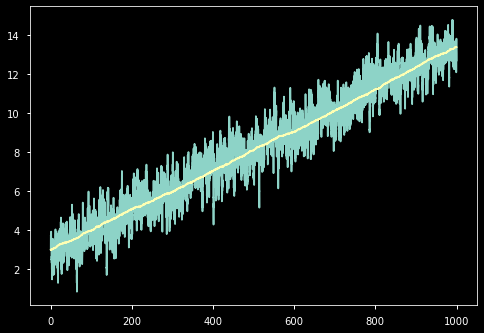

In [100]:
path = sol_ou.p[0]
plt.plot(sol_ou.t, path.T[1])
plt.plot(sol_ou.t, path.T[0]);

In [101]:
data = path[::10]

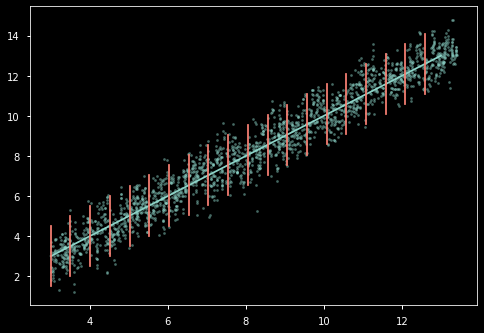

In [102]:
# plt.figure(figsize=(10,7))
plt.scatter(*data.T, s=5, alpha=0.5);
u = np.linspace(3, 13, 100)
plt.plot(u,u);
for u0 in u[::5]:
    u = 50*[u0]
    v = np.linspace(u0-1.5, u0+1.5, 50)
    plt.plot(u, v, color='C3');

In [235]:
# transformation
f = lambda r: jnp.log(1 + r**2)
# g = lambda r: r**3 / (1 + r**2)
g = lambda r: jnp.sin(.5 * r)
ginv = lambda s: 2 * jnp.arcsin(s)

In [236]:
F = lambda u, v: jnp.array([v, f(v) + g(u-v)])
G = lambda x, y: jnp.array([ginv(y-f(x)) + x, x])
# fwdF = lambda u: np.asarray([u[1], np.log(1+u[1])+np.sin(.5*(u[0] - u[1]))])

In [237]:
np.allclose(G(*F(*data.T)).T, data)

True

In [238]:
Fdata = F(*data.T).T

In [239]:
Fdata.shape

(2001, 2)

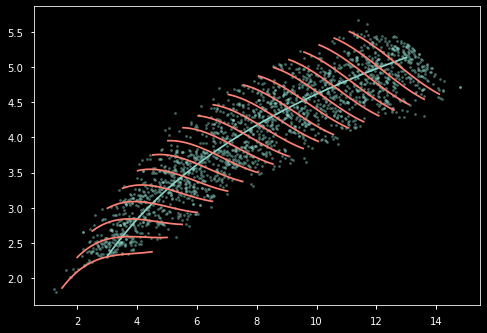

In [272]:
# plt.figure(figsize=(10,7))
plt.scatter(*Fdata.T, alpha=.5, s=5);
u = np.linspace(3, 13, 100)
spine = F(u, u)
plt.plot(*spine);

ends = []
fibers = []
for u0 in u[::5]:
    v = np.linspace(u0-1.5, u0+1.5, 50)
    fibers.append(F(u0, v))
    ends.append(line.T[0])
    plt.plot(*F(u0, v), color='C3')

In [295]:
ends = np.array([fib.T[0] for fib in fibers])

In [296]:
fwdF = lambda uv: F(uv[0], uv[1])
bwdF = lambda xy: G(xy[0], xy[1])

FT = spaths.SDETransform(fwdF, bwdF)
sde_Fou = FT(sde_ou)

### Short trajectories

In [351]:
ens0 = ends

In [352]:
ens0.shape

(20, 2)

In [353]:
Fou_fibers = em.solve(sde_Fou, ends, (0, 100), dt)

In [354]:
Fou_fibers.p.shape

(20, 2002, 2)

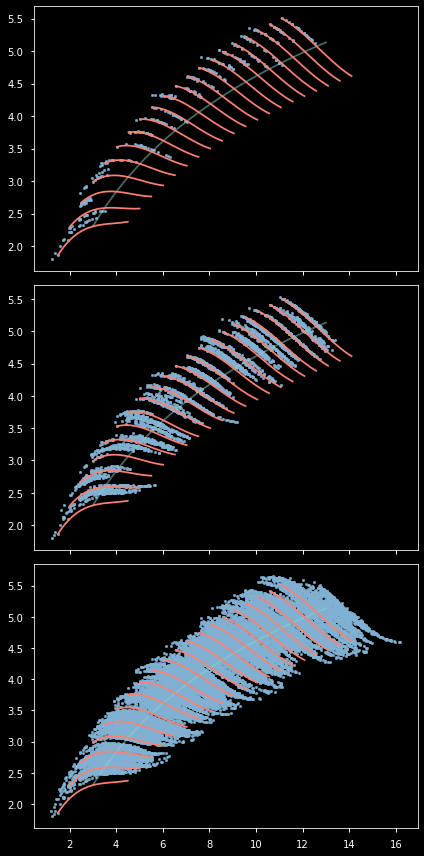

In [378]:
fig, axs = plt.subplots(nrows=3, figsize=(6,12), sharex=True)

for n, ax in enumerate(axs):
    
    ax.plot(*spine, alpha=.5)
    for path, fib in zip(Fou_fibers.p, fibers):
        ax.plot(*fib, color='C3')
        stop = int(len(path)/(10**len(axs)))*10**(n+1)
        ax.scatter(*path[:stop].T, c='C4', s=7)

fig.tight_layout()
plt.show()

In [346]:
nrep = 500
ens0 = np.repeat(ends, nrep, axis=0)

In [418]:
ens0_rep = np.repeat(ends[:,np.newaxis,:], nrep, axis=1)

In [422]:
ens0_rep.shape

(20, 500, 2)

In [347]:
Fou_bursts = em.burst(sde_Fou, ens0, (0, 100), dt).reshape(len(ends), nrep, 2)

In [348]:
Fou_bursts.shape

(20, 500, 2)

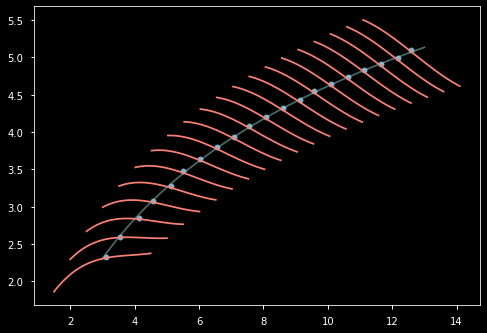

In [350]:
plt.plot(*spine, alpha=.5)
for burst, fib in zip(Fou_bursts, fibers):
    plt.plot(*fib, color='C3')
    mean = np.nanmean(burst, axis=0)
    plt.scatter(*mean.T, c='C4', s=30)

plt.show()